In [1]:
import sys
sys.path.append('../')
from config_sing import *
show_env()

You are in: Singularity | singularity_proj_combeffect
    BASE DIRECTORY:     /mount/work
    PATH OF SOURCE:     /mount/work/source
    PATH OF EXECUTABLE: /mount/work/exe
    PATH OF ANNOTATION: /mount/work/annotation
    PATH OF PROJECT:    /mount/project
    PATH OF RESULTS:    /mount/work/out/proj_combeffect

Library imported:
    numpy, pandas, matplotlib.pyplot
    os, sys, time, gzip, glob



In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns
import xgboost as xgb
import shap
import json

In [3]:
sns.__version__

'0.11.2'

In [4]:
from functools import partial, reduce
print = partial(print, flush=True)

### Set Samples
fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT    = reduce(fun, ["Input", idx])
INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])
SAMPLES  = np.concatenate([INPUT20X, TFX_DMSO, TFX_DEX])

In [5]:
def read_data(sample, fname, cnames):
    fdiry = os.path.join(FD_RES, "scratch", "region_dex_GR_P300_dnase_chr17")
    fname = f"{sample}_{fname}"
    fpath = os.path.join(fdiry, fname)
    dat   = pd.read_csv(fpath, sep = "\t", names=cnames)
    dat   = dat.assign(Sample = sample)
    return dat

read_motif_score = partial(
    read_data, 
    fname="motif_score.tsv", 
    cnames=["Fragment", "Motif"])

read_motif_count = partial(
    read_data, 
    fname="motif_count.tsv", 
    cnames=["Fragment", "Motif"])

read_pct = partial(
    read_data, 
    fname="pct.tsv", 
    cnames=["Fragment", "GC"])

read_depth = partial(
    read_data, 
    fname="depth.tsv", 
    cnames=["Fragment", "Loc", "Depth"])

## Import DMSO

In [6]:
fun = read_motif_score
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_mtf_score = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(10802, 3)
(10802, 3)


,Fragment,Motif,Sample
0,chr17_6001570_6002624,"{""HD/23"": 10.0246, ""SOX/1"": 15.42495, ""EVI1/ME...",TFX2_DMSO
1,chr17_6001571_6002624,"{""SOX/1"": 15.42495, ""EVI1/MECOM"": 7.0973, ""ZNF...",TFX2_DMSO
2,chr17_6001762_6002691,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7...",TFX2_DMSO
3,chr17_6001762_6002692,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7...",TFX2_DMSO
4,chr17_6001763_6002692,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7...",TFX2_DMSO
...,...,...,...
2606,chr17_82268021_82268899,"{""NR/4"": 8.857, ""E2F/2"": 18.1223, ""ZFX"": 18.50...",TFX5_DMSO
2607,chr17_82268031_82268998,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ...",TFX5_DMSO
2608,chr17_82268031_82268999,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ...",TFX5_DMSO
2609,chr17_82268032_82268997,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ...",TFX5_DMSO


In [7]:
fun = read_motif_count
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_mtf_count = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(10802, 3)
(10802, 3)


,Fragment,Motif,Sample
0,chr17_6001570_6002624,"{""HD/23"": 1, ""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF...",TFX2_DMSO
1,chr17_6001571_6002624,"{""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF768"": 1, ""NF...",TFX2_DMSO
2,chr17_6001762_6002691,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1...",TFX2_DMSO
3,chr17_6001762_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1...",TFX2_DMSO
4,chr17_6001763_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1...",TFX2_DMSO
...,...,...,...
2606,chr17_82268021_82268899,"{""NR/4"": 1, ""E2F/2"": 2, ""ZFX"": 2, ""NR/3"": 4, ""...",TFX5_DMSO
2607,chr17_82268031_82268998,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""...",TFX5_DMSO
2608,chr17_82268031_82268999,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""...",TFX5_DMSO
2609,chr17_82268032_82268997,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""...",TFX5_DMSO


## Import Dex

In [8]:
fun = read_motif_score
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dex_mtf_score = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(39176, 3)
(39176, 3)


,Fragment,Motif,Sample
0,chr17_6001786_6002741,"{""SIX/1"": 8.5294, ""HIC/1"": 24.9856, ""P53-like/...",TFX2_Dex
1,chr17_6001796_6002785,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-...",TFX2_Dex
2,chr17_6001796_6002786,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-...",TFX2_Dex
3,chr17_6001797_6002783,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-...",TFX2_Dex
4,chr17_6001797_6002786,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-...",TFX2_Dex
...,...,...,...
11873,chr17_82267754_82268685,"{""MAF"": 9.6645, ""Ebox/CAGATGG"": 35.51705, ""ZNF...",TFX5_Dex
11874,chr17_82267762_82268716,"{""ZNF320"": 21.0008, ""GC-tract"": 53.11818, ""SMA...",TFX5_Dex
11875,chr17_82267763_82268716,"{""ZNF320"": 21.0008, ""GC-tract"": 53.11818, ""SMA...",TFX5_Dex
11876,chr17_82267768_82268716,"{""SMARCA5"": 11.531, ""ZNF143"": 6.6565, ""ZNF134""...",TFX5_Dex


In [9]:
fun = read_motif_count
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dex_mtf_count = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(39176, 3)
(39176, 3)


,Fragment,Motif,Sample
0,chr17_6001786_6002741,"{""SIX/1"": 1, ""HIC/1"": 3, ""P53-like/1"": 2, ""GC-...",TFX2_Dex
1,chr17_6001796_6002785,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""...",TFX2_Dex
2,chr17_6001796_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""...",TFX2_Dex
3,chr17_6001797_6002783,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""...",TFX2_Dex
4,chr17_6001797_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""...",TFX2_Dex
...,...,...,...
11873,chr17_82267754_82268685,"{""MAF"": 1, ""Ebox/CAGATGG"": 4, ""ZNF320"": 2, ""GC...",TFX5_Dex
11874,chr17_82267762_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN...",TFX5_Dex
11875,chr17_82267763_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN...",TFX5_Dex
11876,chr17_82267768_82268716,"{""SMARCA5"": 2, ""ZNF143"": 1, ""ZNF134"": 2, ""INSM...",TFX5_Dex


## Combine

In [10]:
dat1 = dat_dmso_mtf_score
dat2 = dat_dex_mtf_score

lst = dat1["Motif"].to_list() + dat2["Motif"].to_list()
lst = list(map(json.loads, lst))
dat = pd.DataFrame.from_dict(lst).fillna(0)

lst = dat1["Sample"].to_list() + dat2["Sample"].to_list()
dat = dat.assign(Sample = lst)

lst = np.r_[np.repeat("TFX_DMSO", dat1.shape[0]), np.repeat("TFX_Dex", dat2.shape[0])]
dat = dat.assign(Group = lst)

### asssign
dat_mtf_score = dat
print(dat.shape)
dat

(49978, 271)


,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO,Sample,Group
0,10.0246,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
1,0.0000,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
2,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
3,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
4,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex
49974,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex
49975,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex
49976,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,43.15858,9.6538,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex


In [11]:
dat1 = dat_dmso_mtf_count
dat2 = dat_dex_mtf_count

lst = dat1["Motif"].to_list() + dat2["Motif"].to_list()
lst = list(map(json.loads, lst))
dat = pd.DataFrame.from_dict(lst).fillna(0)

lst = dat1["Sample"].to_list() + dat2["Sample"].to_list()
dat = dat.assign(Sample = lst)

lst = np.r_[np.repeat("TFX_DMSO", dat1.shape[0]), np.repeat("TFX_Dex", dat2.shape[0])]
dat = dat.assign(Group = lst)

### asssign
dat_mtf_count = dat
print(dat.shape)
dat

(49978, 271)


,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO,Sample,Group
0,1.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
1,0.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
2,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
3,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
4,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX2_DMSO,TFX_DMSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex
49974,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex
49975,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex
49976,0.0,1.0,0.0,4.0,0.0,1.0,5.0,1.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TFX5_Dex,TFX_Dex


## Store the table

## Plot

In [12]:
plt.style.use("seaborn-whitegrid")

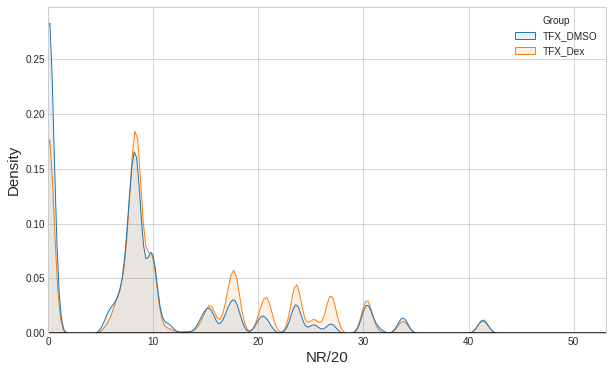

In [13]:
mtf = "NR/20"
dat = dat_mtf_score
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
sns.kdeplot(
    ax = ax,
    data=dat, 
    x=mtf, 
    hue="Group", 
    fill=True,
    alpha=0.1,
    bw_method=0.05, 
    common_norm=False).set(xlim=(0))
ax.axhline(y=0, c="black")
ax.set_xlabel(mtf, fontsize=15)
ax.set_ylabel("Density", fontsize=15)
#ax.axvline(x=0, c="black", linewidth=4)
plt.show()

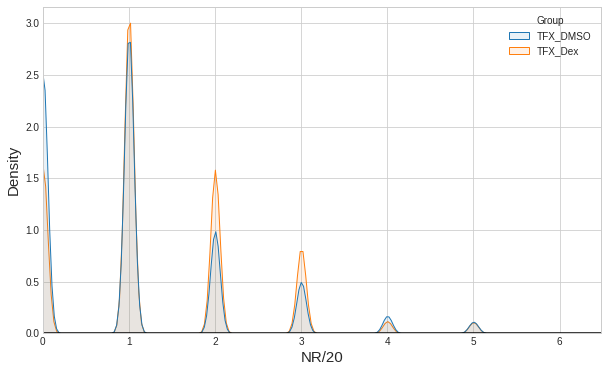

In [18]:
mtf = "NR/20"
dat = dat_mtf_count
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
sns.kdeplot(
    ax = ax,
    data=dat, 
    x=mtf, 
    hue="Group", 
    fill=True,
    alpha=0.1,
    bw_method=0.05, 
    common_norm=False).set(xlim=(0))
ax.axhline(y=0, c="black")
ax.set_xlabel(mtf, fontsize=15)
ax.set_ylabel("Density", fontsize=15)
#ax.axvline(x=0, c="black", linewidth=4)
plt.show()

In [16]:
%load_ext rpy2.ipython

In [17]:
%%R
print(1)

[1] 1


In [ ]:
%%R -i dat_mtf_count
dat = dat_mtf_count


In [75]:
mtf = "NR/20"
dat = dat_mtf_count
dat[mtf]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
49973    1.0
49974    1.0
49975    1.0
49976    1.0
49977    1.0
Name: NR/20, Length: 49978, dtype: float64

In [118]:
mtf = "NR/20"
dat = dat_mtf_count

dat = dat[mtf].groupby(dat["Group"]).value_counts(normalize=True)
dat = pd.DataFrame(dat).set_axis(["Frequency"], axis=1).reset_index()
dat

,Group,NR/20,Frequency
0,TFX_DMSO,1.0,0.401870
1,TFX_DMSO,0.0,0.352620
2,TFX_DMSO,2.0,0.137382
3,TFX_DMSO,3.0,0.069154
4,TFX_DMSO,4.0,0.023422
5,TFX_DMSO,5.0,0.015553
6,TFX_Dex,1.0,0.420308
7,TFX_Dex,0.0,0.221998
8,TFX_Dex,2.0,0.214289
9,TFX_Dex,3.0,0.112492


In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
sns.barplot(ax = ax, data = dat, x="NR/20", y="Frequency", hue="Group")

In [81]:
type(dat)

pandas.core.series.Series

AttributeError: 'Rectangle' object has no property 'stat'

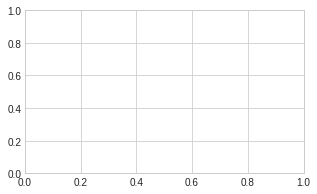

In [76]:

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))
sns.countplot(
    ax = ax,
    data=dat, 
    x=mtf, 
    hue="Group", 
    fill=True,
    alpha=0.7,
    stat = 'probability',
    common_norm=False,
    multiple = "dodge")
ax.axhline(y=0, c="black")
#ax.axvline(x=0, c="black", linewidth=4)
plt.show()

In [9]:
dat_mtf["NR/20"]

0        0.0000
1        0.0000
2        0.0000
3        0.0000
4        0.0000
          ...  
49973    8.1144
49974    8.1144
49975    8.1144
49976    8.1144
49977    8.1144
Name: NR/20, Length: 49978, dtype: float64

In [10]:
sns.distplot

<function seaborn.distributions.distplot(a=None, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None, x=None)>

In [11]:
sns.histplot

<function seaborn.distributions.histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)>

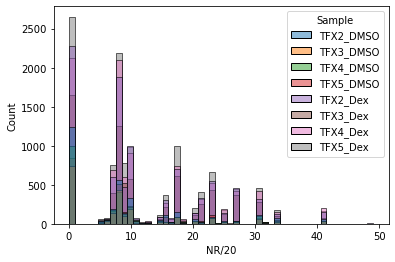

In [18]:
sns.histplot(data=dat_mtf, x="NR/20", hue="Sample")

In [35]:
plt.style.use("seaborn-whitegrid")

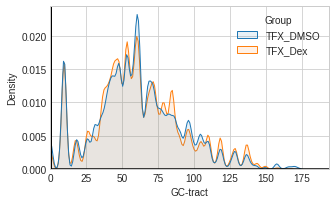

In [54]:
x = "GC-tract"
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))
sns.kdeplot(
    ax = ax,
    data=dat_mtf, 
    x=x, 
    hue="Group", 
    fill=True,
    alpha=0.1,
    bw_method=0.05, 
    common_norm=False).set(xlim=(0))
ax.axhline(y=0, c="black")
ax.axvline(x=0, c="black", linewidth=4)
plt.show()

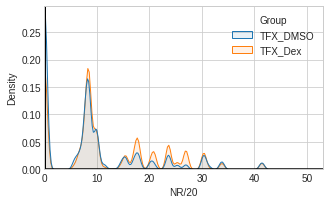

In [50]:
x = "NR/20"
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))
sns.kdeplot(
    ax = ax,
    data=dat_mtf, 
    x=x, 
    hue="Group", 
    fill=True,
    alpha=0.1,
    bw_method=0.05, 
    common_norm=False).set(xlim=(0))
ax.axhline(y=0, c="black")
ax.axvline(x=0, c="black", linewidth=4)
plt.show()

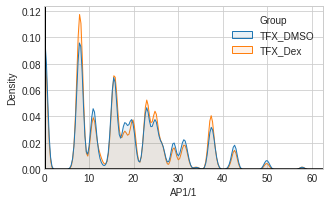

In [52]:
x = "AP1/1"
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))
sns.kdeplot(
    ax = ax,
    data=dat_mtf, 
    x=x, 
    hue="Group", 
    fill=True,
    alpha=0.1,
    bw_method=0.05, 
    common_norm=False).set(xlim=(0))
ax.axhline(y=0, c="black")
ax.axvline(x=0, c="black", linewidth=4)
plt.show()